In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import shutil
import glob
import io
import os
import pathlib
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import yaml
import random
import pandas as pd

In [2]:
#pip install roboflow

In [3]:
#yolov8

#!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YHTjnmxe3lRU4B3THhhe")
project = rf.workspace("car-damage-detection-cardd").project("car-damage-severity-detection-cardd")
version = project.version(3)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...


##### Create a dataset



In [4]:
#data_dir = pathlib.Path("./Damaged-Vehicle-Images-1/train")
#data_dir = pathlib.Path("./2---Car-damage--3/train")
data_dir = pathlib.Path("./Car-Damage-Severity-Detection/CarDD-3/train")
labels_dir = "./Car-Damage-Severity-Detection/CarDD-3/train/labels"

data_path = pathlib.Path("./Car-Damage-Severity-Detection/CarDD-3/valid")
labels_path = "./Car-Damage-Severity-Detection/CarDD-3/valid/labels"



DEsta vez, como cada imagem pode ter mais do que uma label, em vez das classes estarem em pastas, estao todas no ficheiro yaml


In [5]:
class_ids = set()

for fname in os.listdir(labels_dir):
    if not fname.endswith('.txt'): continue
    with open(os.path.join(labels_dir, fname)) as f:
        for line in f:
            cid = int(line.split()[0])
            class_ids.add(cid)

print('IDs de classes:', sorted(class_ids))
print(f'Total de classes: {len(class_ids)}')

IDs de classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Total de classes: 11


In [6]:
with open('./Car-Damage-Severity-Detection/CarDD-3/data.yaml') as f:
    data = yaml.safe_load(f)

print('Nomes de classe:', data['names'])

Nomes de classe: ['car-part-crack', 'detachment', 'flat-tire', 'glass-crack', 'lamp-crack', 'minor-deformation', 'moderate-deformation', 'paint-chips', 'scratches', 'severe-deformation', 'side-mirror-crack']


Há 11 classes. nas imagens tem os id's e o yaml indica qual o correspondente nome


In [7]:
print("Nomes de classe (ID → nome):")
for idx, name in enumerate(data['names']):
    print(idx, name)

Nomes de classe (ID → nome):
0 car-part-crack
1 detachment
2 flat-tire
3 glass-crack
4 lamp-crack
5 minor-deformation
6 moderate-deformation
7 paint-chips
8 scratches
9 severe-deformation
10 side-mirror-crack


In [8]:
base = "./Car-Damage-Severity-Detection/CarDD-3"
print("Conteúdo de CarDD-3:", os.listdir(base))
for sub in os.listdir(base):
    subpath = os.path.join(base, sub)
    if os.path.isdir(subpath):
        print(f" - {sub}:", os.listdir(subpath))


Conteúdo de CarDD-3: ['data.yaml', 'README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']
 - test: ['images', 'labels']
 - train: ['images', 'labels']
 - valid: ['images', 'labels']


### Visualise the dataset




*   train set





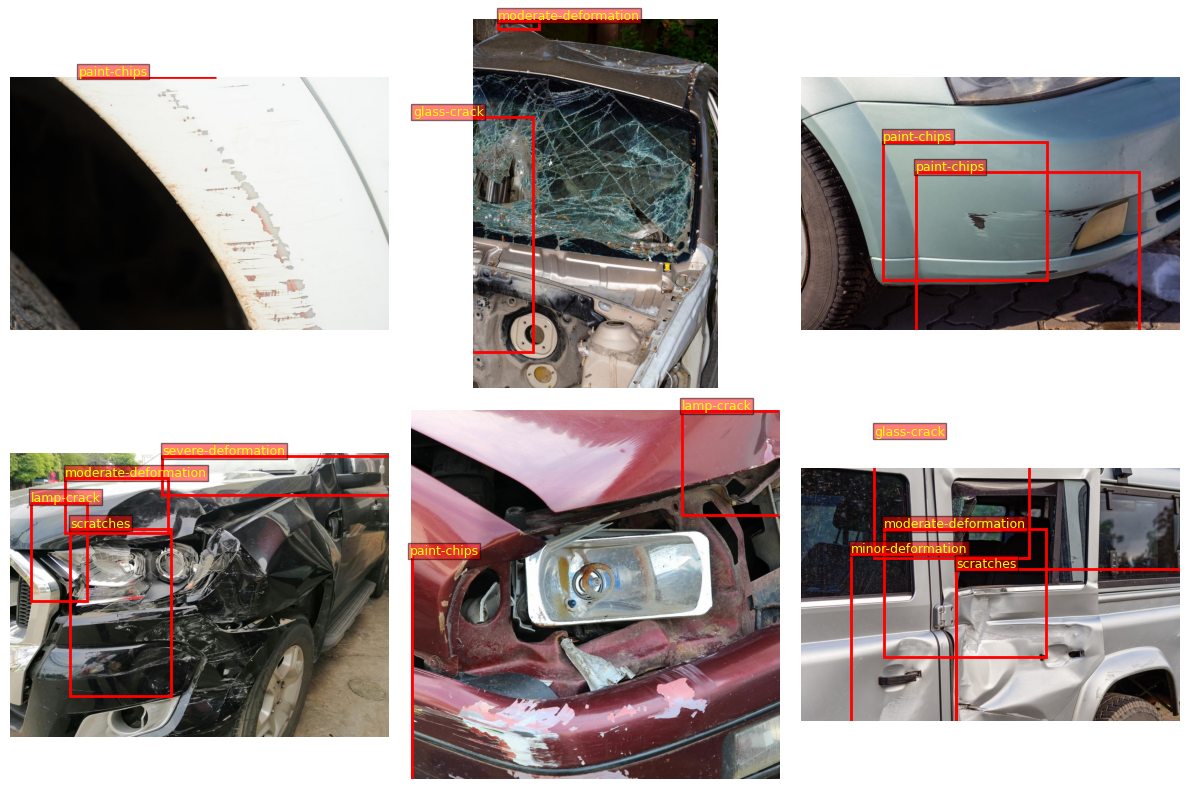

In [9]:
#labels
with open("./Car-Damage-Severity-Detection/CarDD-3/data.yaml") as f:
    data = yaml.safe_load(f)
class_names = data["names"]

#ver o train set
split = "train"
img_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/images"
lbl_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/labels"


imgs = [f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")]
sample = random.sample(imgs, 6)
fig = plt.figure(figsize=(12, 8))
for i, fname in enumerate(sample, 1):
    img = Image.open(os.path.join(img_dir, fname))
    w, h = img.size

    boxes = []
    with open(os.path.join(lbl_dir, fname.replace(".jpg", ".txt"))) as f_lbl:
        for line in f_lbl:
            vals = line.split()
            cid = int(vals[0])
            x_center, y_center, bw, bh = map(float, vals[1:5])
            x1 = (x_center - bw/2) * w
            y1 = (y_center - bh/2) * h
            boxes.append((cid, x1, y1, bw*w, bh*h))

    ax = fig.add_subplot(2, 3, i)
    ax.imshow(img); ax.axis("off")

    for cid, x1, y1, bw_px, bh_px in boxes:
        rect = patches.Rectangle((x1, y1), bw_px, bh_px,
                                 linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1-5, class_names[cid],
                fontsize=9, color="yellow",
                bbox=dict(facecolor="red", alpha=0.5, pad=1))

plt.tight_layout()
plt.show()



*   validation set


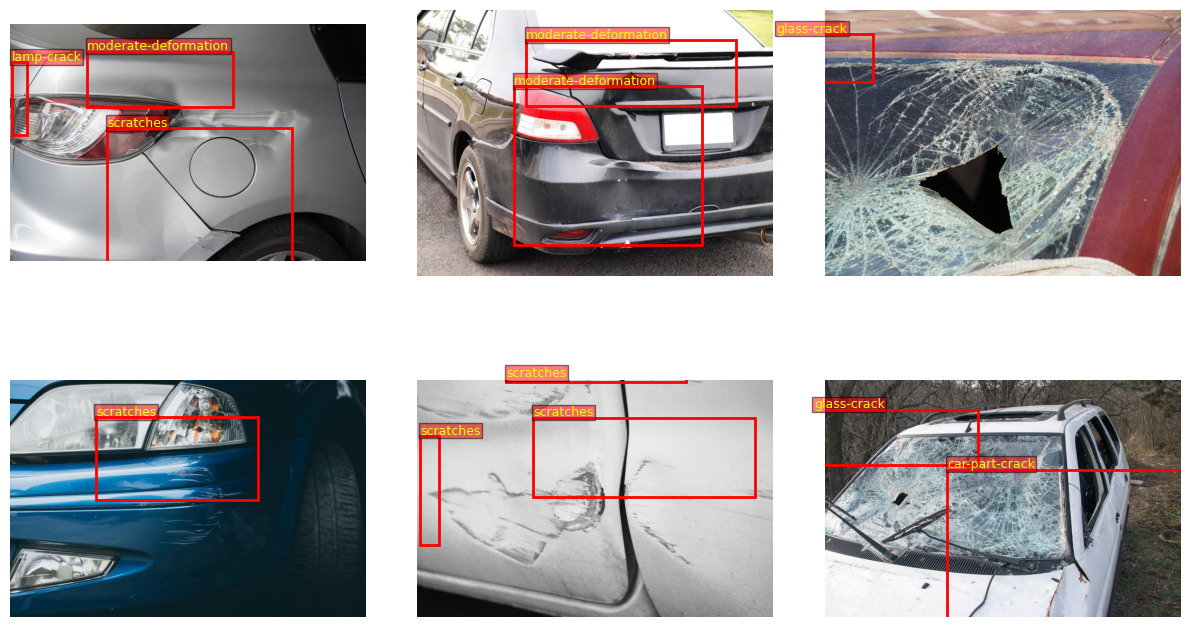

In [10]:
#labels
with open("./Car-Damage-Severity-Detection/CarDD-3/data.yaml") as f:
    data = yaml.safe_load(f)
class_names = data["names"]

#ver o valid set
split = "valid"
img_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/images"
lbl_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/labels"


imgs = [f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")]
sample = random.sample(imgs, 6)
fig = plt.figure(figsize=(12, 8))
for i, fname in enumerate(sample, 1):
    img = Image.open(os.path.join(img_dir, fname))
    w, h = img.size

    boxes = []
    with open(os.path.join(lbl_dir, fname.replace(".jpg", ".txt"))) as f_lbl:
        for line in f_lbl:
            vals = line.split()
            cid = int(vals[0])
            x_center, y_center, bw, bh = map(float, vals[1:5])
            x1 = (x_center - bw/2) * w
            y1 = (y_center - bh/2) * h
            boxes.append((cid, x1, y1, bw*w, bh*h))

    ax = fig.add_subplot(2, 3, i)
    ax.imshow(img); ax.axis("off")

    for cid, x1, y1, bw_px, bh_px in boxes:
        rect = patches.Rectangle((x1, y1), bw_px, bh_px,
                                 linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1-5, class_names[cid],
                fontsize=9, color="yellow",
                bbox=dict(facecolor="red", alpha=0.5, pad=1))

plt.tight_layout()
plt.show()


In [11]:
#!sed -n '1,20p' Car-Damage-Severity-Detection/CarDD-3/data.yaml


---

In [12]:
BASE = pathlib.Path("./Car-Damage-Severity-Detection/CarDD-3")
with open(BASE/"data.yaml") as f:
    class_names = yaml.safe_load(f)["names"]

In [13]:
#lista de labels para o train set:
records = []
for img in (BASE/"train"/"images").glob("*.jpg"):
    lbl = (BASE/"train"/"labels"/(img.stem + ".txt")).read_text().splitlines()
    if not lbl:
        continue
    cid = int(lbl[0].split()[0])
    records.append({"filepath": str(img), "label": class_names[cid]}) #nomes das labels
    #records.append({"filepath": str(img), "label": cid }) #label id (so o numero)

df_train = pd.DataFrame(records)
print(df_train)

                                               filepath                 label
0     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
1     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
2     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
3     Car-Damage-Severity-Detection\CarDD-3\train\im...     minor-deformation
4     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
...                                                 ...                   ...
1383  Car-Damage-Severity-Detection\CarDD-3\train\im...           glass-crack
1384  Car-Damage-Severity-Detection\CarDD-3\train\im...           glass-crack
1385  Car-Damage-Severity-Detection\CarDD-3\train\im...           glass-crack
1386  Car-Damage-Severity-Detection\CarDD-3\train\im...             scratches
1387  Car-Damage-Severity-Detection\CarDD-3\train\im...  moderate-deformation

[1388 rows x 2 columns]


In [14]:
#lista de labels para o valid set:
records = []
for img in (BASE/"valid"/"images").glob("*.jpg"):
    lbl = (BASE/"valid"/"labels"/(img.stem + ".txt")).read_text().splitlines()
    if not lbl:
        continue
    cid = int(lbl[0].split()[0])
    records.append({"filepath": str(img), "label": class_names[cid]}) #nomes das labels
    #records.append({"filepath": str(img), "label": cid }) #label id (so o numero)

df_valid = pd.DataFrame(records)
print(df_valid)

                                              filepath                 label
0    Car-Damage-Severity-Detection\CarDD-3\valid\im...           paint-chips
1    Car-Damage-Severity-Detection\CarDD-3\valid\im...             scratches
2    Car-Damage-Severity-Detection\CarDD-3\valid\im...             scratches
3    Car-Damage-Severity-Detection\CarDD-3\valid\im...     minor-deformation
4    Car-Damage-Severity-Detection\CarDD-3\valid\im...  moderate-deformation
..                                                 ...                   ...
396  Car-Damage-Severity-Detection\CarDD-3\valid\im...           glass-crack
397  Car-Damage-Severity-Detection\CarDD-3\valid\im...  moderate-deformation
398  Car-Damage-Severity-Detection\CarDD-3\valid\im...  moderate-deformation
399  Car-Damage-Severity-Detection\CarDD-3\valid\im...     minor-deformation
400  Car-Damage-Severity-Detection\CarDD-3\valid\im...    severe-deformation

[401 rows x 2 columns]


In [15]:
#map string para int
class_to_idx = { name: idx for idx, name in enumerate(class_names) }

df_train['label_id'] = df_train['label'].map(class_to_idx)
df_valid['label_id'] = df_valid['label'].map(class_to_idx)

In [16]:
df_valid['label_id']

0      7
1      8
2      8
3      5
4      6
      ..
396    3
397    6
398    6
399    5
400    9
Name: label_id, Length: 401, dtype: int64

In [17]:
#extrair arrays
filepaths = df_train['filepath'].to_numpy()
labels = df_train['label_id'].to_numpy().astype(np.int32)

filepaths_val = df_valid['filepath'].to_numpy()
labels_val = df_valid['label_id'].to_numpy().astype(np.int32)

In [18]:
img_height = 180
img_width  = 180
batch_size = 32

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0
    return img, label

In [19]:

ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
ds_val = tf.data.Dataset.from_tensor_slices((filepaths_val, labels_val))


#### * `Dataset.cache` keeps the images in memory after they are loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model.
#### * `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [20]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

In [21]:
train_ds = (ds
    .shuffle(len(filepaths))
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (ds_val
    .shuffle(len(filepaths_val))
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [22]:
#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

pip install ultralytics


!yolo detect train \
  model=yolov8s.pt \
  data=Car-Damage-Severity-Detection/CarDD-3/data.yaml \
  epochs=50 \
  imgsz=640 \
  batch=16


#### Data Augmentation

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


#### Visualize a few augmented examples by applying data augmentation to the same image several times:

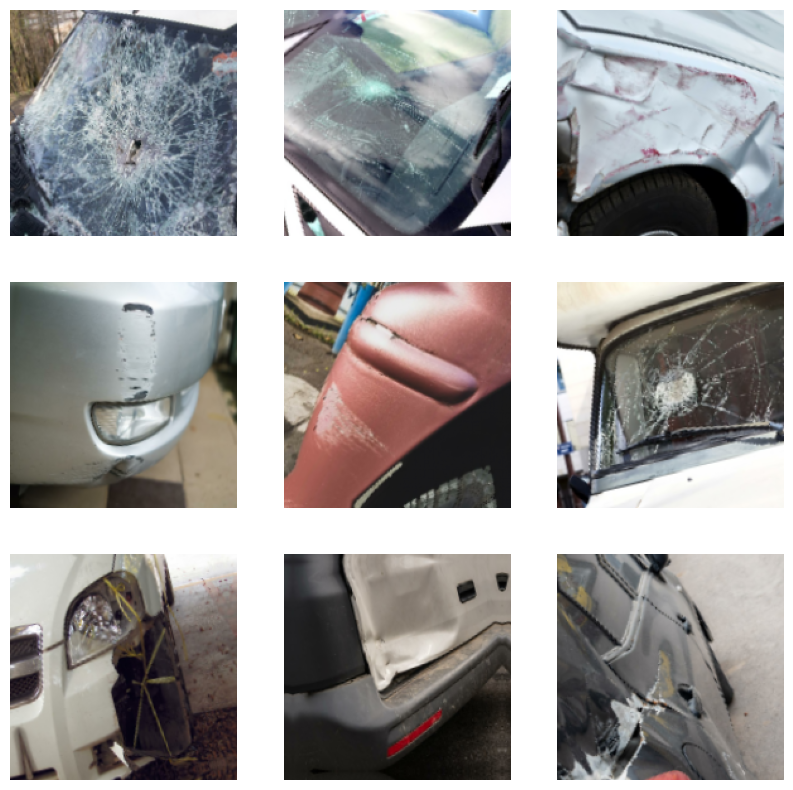

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        aug = data_augmentation(tf.expand_dims(images[i], 0))[0].numpy()
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(aug)
        plt.axis("off")
plt.show()

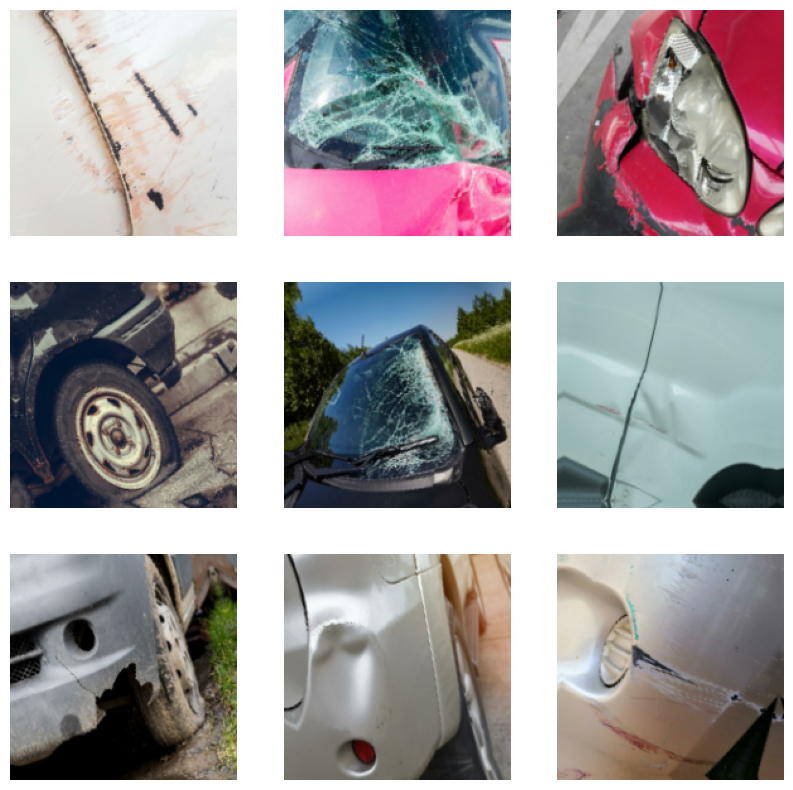

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        aug = data_augmentation(tf.expand_dims(images[i], 0))[0].numpy()
        aug_uint8 = (aug * 255).astype("uint8")
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(aug_uint8)
        plt.axis("off")
plt.show()


In [26]:
tf.expand_dims(images[i], 0)


<tf.Tensor: shape=(1, 180, 180, 3), dtype=float32, numpy=
array([[[[0.8155955 , 0.8155955 , 0.8155955 ],
         [0.8430828 , 0.8430828 , 0.8430828 ],
         [0.8617465 , 0.8617465 , 0.8617465 ],
         ...,
         [0.34486195, 0.31022173, 0.3439907 ],
         [0.32489082, 0.28567514, 0.3170477 ],
         [0.31207347, 0.27677935, 0.28854406]],

        [[0.8246187 , 0.8246187 , 0.8246187 ],
         [0.8560458 , 0.8560458 , 0.8560458 ],
         [0.8627451 , 0.8627451 , 0.8627451 ],
         ...,
         [0.3515795 , 0.3169393 , 0.35070825],
         [0.345099  , 0.30588332, 0.33725587],
         [0.30882353, 0.2735294 , 0.28529412]],

        [[0.83346045, 0.83346045, 0.83346045],
         [0.85081697, 0.85081697, 0.85081697],
         [0.8666667 , 0.8666667 , 0.8666667 ],
         ...,
         [0.35579148, 0.3211513 , 0.35492024],
         [0.34640604, 0.30719036, 0.3385629 ],
         [0.31154707, 0.27625296, 0.28801766]],

        ...,

        [[0.77997464, 0.66298103, 

## Model

In [27]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation, # layer of data augmentation
  layers.Rescaling(1./255), # standardize data
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # dropout layer
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

#### Compile the model

We will use the Adam optimizer `tf.keras.optimizers.Adam` and as loss function the cross entropy `tf.keras.losses.SparseCategoricalCrossentropy`. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.


In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,990,059 (15.22 MB)

 Trainable params: 3,990,059 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

Train the model for 15 epochs with the Keras `Model.fit` method:

In [30]:
epochs=500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.2682 - loss: 2.0447 - val_accuracy: 0.2943 - val_loss: 1.8389
Epoch 2/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.3079 - loss: 1.8295 - val_accuracy: 0.2943 - val_loss: 1.8371
Epoch 3/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.3086 - loss: 1.8259 - val_accuracy: 0.2943 - val_loss: 1.8317
Epoch 4/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.3082 - loss: 1.8230 - val_accuracy: 0.2943 - val_loss: 1.8330
Epoch 5/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.3084 - loss: 1.8233 - val_accuracy: 0.2943 - val_loss: 1.8386
Epoch 6/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.3086 - loss: 1.8243 - val_accuracy: 0.2943 - val_loss: 1.8387
Epoch 7/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.3112 - loss: 1.8245 - val_accuracy: 0.2943 - val_loss: 1.8457
Epoch 8/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.3114 - loss: 1.8259 - val_accu

#### Visualise training results

Create plots of the loss and accuracy on the training and validation sets:

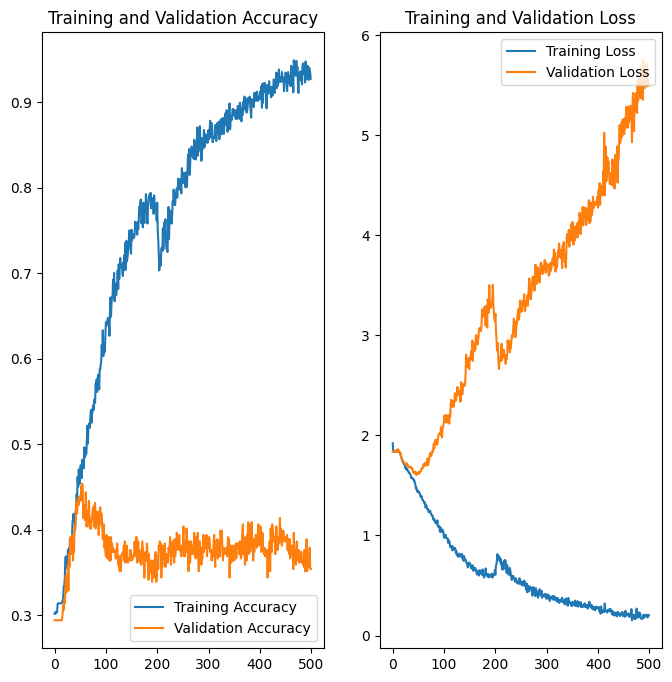

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

isto está estranho, precisa mais epochs?

In [35]:
image_upload = "https://brightonpanelworks.com.au/wp-content/uploads/2019/10/auto-3734396_1280.jpg"
image_path = tf.keras.utils.get_file('grey_BMW', origin = image_upload)

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
This image most likely belongs to car-part-crack with a 100.00 percent confidence.
